In [1]:
# import the necessary packages
import numpy as np
import os
import h5py
from glob import glob
import string

import matplotlib.pyplot as plt
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet

from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, Convolution2D, MaxPooling2D, Activation
from keras.models import Sequential, Model
from keras.callbacks import History, ModelCheckpoint, Callback
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier


Using TensorFlow backend.


## LOAD BOTTLENECK FEATURES

In [2]:
#LOAD DATA

vgg_train = np.load("../bottleneck_features/vgg16_train_bottleneck_features.pkl_01.npy")
vgg_train_y = np.load("../bottleneck_features/vgg16_train_bottleneck_labels.pkl")
vgg_test = np.load("../bottleneck_features/vgg16_test_bottleneck_features.pkl_01.npy")
vgg_test_y = np.load("../bottleneck_features/vgg16_test_bottleneck_labels.pkl")

res_train = np.load("../bottleneck_features/resnet_train_bottleneck_features.pkl_01.npy")
res_train_y = np.load("../bottleneck_features/resnet_train_bottleneck_labels.pkl")
res_test = np.load("../bottleneck_features/resnet_test_bottleneck_features.pkl_01.npy")
res_test_y = np.load("../bottleneck_features/resnet_test_bottleneck_labels.pkl")

inc_train = np.load("../bottleneck_features/inception_train_bottleneck_features.pkl_01.npy")
inc_train_y = np.load("../bottleneck_features/inception_train_bottleneck_labels.pkl")
inc_test = np.load("../bottleneck_features/inception_test_bottleneck_features.pkl_01.npy")
inc_test_y = np.load("../bottleneck_features/inception_test_bottleneck_labels.pkl")

xc_train = np.load("../bottleneck_features/xception_train_bottleneck_features.pkl_01.npy")
xc_train_y = np.load("../bottleneck_features/xception_train_bottleneck_labels.pkl")
xc_test = np.load("../bottleneck_features/xception_test_bottleneck_features.pkl_01.npy")
xc_test_y = np.load("../bottleneck_features/xception_test_bottleneck_labels.pkl")

mob_train = np.load("../bottleneck_features/mobilenet_train_bottleneck_features.pkl_01.npy")
mob_train_y = np.load("../bottleneck_features/mobilenet_train_bottleneck_labels.pkl")
mob_test = np.load("../bottleneck_features/mobilenet_test_bottleneck_features.pkl_01.npy")
mob_test_y = np.load("../bottleneck_features/mobilenet_test_bottleneck_labels.pkl")

In [ ]:
print(np.array(vgg_train).shape, np.array(vgg_test).shape)
print(np.array(vgg_train_y).shape, np.array(vgg_test_y).shape)

In [ ]:
print(np.array(res_train).shape, np.array(res_test).shape)
print(np.array(res_train_y).shape, np.array(res_test_y).shape)

In [ ]:
print(np.array(inc_train).shape, np.array(inc_test).shape)
print(np.array(inc_train_y).shape, np.array(inc_test_y).shape)

In [ ]:
print(np.array(xc_train).shape, np.array(xc_test).shape)
print(np.array(xc_train_y).shape, np.array(xc_test_y).shape)

In [ ]:
print(np.array(mob_train).shape, np.array(mob_test).shape)
print(np.array(mob_train_y).shape, np.array(mob_test_y).shape)

## TRAIN CLASSIFICATION BLOCK

In [ ]:
vgg = [vgg_train, vgg_train_y, vgg_test, vgg_test_y]
res = [res_train, res_train_y, res_test, res_test_y]
inc = [inc_train, inc_train_y, inc_test, inc_test_y]
xc = [xc_train, xc_train_y, xc_test,xc_test_y]
mob = [mob_train, mob_train_y, mob_test, mob_test_y]

In [ ]:
def my_preprocess(x):
    train_y = to_categorical(x[1], num_classes=26)
    test_y = to_categorical(x[3], num_classes=26)
    reshaped_test = x[2].reshape(x[2].shape[0], -1)
    reshaped_train = x[0].reshape(x[0].shape[0], -1)
    return (train_y, test_y, reshaped_train, reshaped_test)
    assert(train_x.shape[1] == test_x.shape[1])

In [ ]:
#################
batch_size = 32
nb_classes = 26
nb_epoch = 100
image_size = 244
num_channels = 'rgb'
#################

names = ["mob"]
c = 0

for net in [mob]:
            
    train_y, test_y, train_x, test_x = my_preprocess(net)
    filepath = "snapshot_" + names[c] + "_weights.hdf5"
    
    # TO SAVE CONTINUOUS SNAPSHOTS
    save_snapshots = ModelCheckpoint(filepath,
                                     monitor='val_acc',
                                     save_best_only=True,
                                     save_weights_only=True,
                                     mode='max',
                                     verbose=1)
    
    # Save loss history
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.accuracy = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.accuracy.append(logs.get('acc'))

    loss_history = LossHistory()
    callbacks_list = [save_snapshots, loss_history]
    
    # LOAD MODEL
    
    print("loading model...")
    model = Sequential()

    model.add(Dense(256, input_shape=(train_x.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    print("model loaded.")
    
    # TRAIN MODEL
    
    print("fitting model...")
    
    neural_net = model.fit(train_x, train_y, batch_size=64, epochs=50, verbose=0, callbacks=callbacks_list, 
                         validation_split=0.0, validation_data=(test_x, test_y), shuffle=True, 
                         class_weight=None, sample_weight=None, initial_epoch=0)
    
    print("done!")
    print("saving logs + weights...")
    
    # SAVE WEIGHTS + LOGS
    #model.save_weights(filepath)
    
    evaluation_cost = neural_net.history['val_loss']
    evaluation_accuracy = neural_net.history['val_acc']
    training_cost = neural_net.history['loss']
    training_accuracy = neural_net.history['acc']

    np.save(names[c] + "_evaluation_cost.npy", evaluation_cost)
    np.save(names[c] + "_evaluation_accuracy.npy", evaluation_accuracy)
    np.save(names[c] + "_training_cost.npy", training_cost)
    np.save(names[c] + "_training_accuracy.npy", training_accuracy)
    c+=1



### OTHER APPROACHES

In [ ]:
# Create label dictionary
label_dict = {}
for pos, letter in enumerate(string.ascii_lowercase):
    label_dict[pos] = letter

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import numpy as np

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC

from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                           min_samples_split=2, min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_split=1e-07, 
                           bootstrap=True, oob_score=False, n_jobs=-1, 
                           random_state=123, verbose=0, warm_start=False, 
                           class_weight=None)

ovr = OneVsRestClassifier(LinearSVC(random_state=123), n_jobs=-1)



In [ ]:
# RANDOM FOREST

scores = []
for net in [vgg, res, inc, xc, mob]:
    train_y, test_y, train_x, test_x = my_preprocess(net)
    rf.fit(X=train_x, y=train_y)
    scores.append(rf.score(X=test_x, y=test_y))
    
list(zip(["vgg", "res", "inc", "xc", "mob"], scores))

In [ ]:
# LINEAR REGRESSION

scores = []
for net in [vgg, res, inc, xc, mob]:
    train_y, test_y, train_x, test_x = my_preprocess(net)
    ovr.fit(X=train_x, y=train_y)
    scores.append(ovr.score(X=test_x, y=test_y))
    
list(zip(["vgg", "res", "inc", "xc", "mob"], scores))

ovr.fit(X=reshaped_train, y=train_y)

In [ ]:
ada = AdaBoostClassifier(base_estimator=None, n_estimators=50, 
                         learning_rate=1.0, algorithm='SAMME.R', random_state=123)

In [ ]:
ada.fit(X=reshaped_train, y=res_train_y[:res_train.shape[0]])

In [ ]:
ada.score(X=reshaped_test, y=(res_test_y[:res_test.shape[0]]))

In [ ]:
gd = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                                subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_split=1e-07, init=None, 
                                random_state=123, max_features=None, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, presort='auto')

In [ ]:
gd.fit(X=reshaped_train, y=res_train_y[:res_train.shape[0]])

In [ ]:
gd.score(X=reshaped_test, y=(res_test_y[:res_test.shape[0]])

# OTHER

In [ ]:


vgg_model = VGG16(include_top=False)
res_model = ResNet50(include_top=False)


def preprocess_for_vgg(image, size=224, color=True):
    image = cv2.resize(image, (size, size))
    x = np.array(image, dtype=float)
    x_fake_batch = x.reshape(1, *x.shape)
    x = x_fake_batch
    # 'BGR' -> 'RGB'
    #x = x[:, :, :, ::-1]
    if color:
        # Zero-center by mean pixel
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
    return x

#convert class letters to integer values

img_a = cv2.imread("../../train_data/FINAL_DATA/grayscale/train/a/my_gray_processed_a_029.png",0)

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline

import matplotlib



def plot_logs(evaluation_cost, evaluation_accuracy, training_cost, training_accuracy):
    #evaluation_cost = history.history['val_loss']
    #evaluation_accuracy = history.history['val_acc']
    #training_cost = history.history['loss']
    #training_accuracy = history.history['acc']
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(10)
    ax1.plot(evaluation_cost,label= 'test')
    ax1.plot(training_cost, label='train')
    ax1.set_title('Cost')
    ax1.legend()
    ax2.plot(evaluation_accuracy, label='test')
    ax2.plot(training_accuracy, label='train')
    ax2.set_title('Accuracy')
    ax2.legend(loc='lower right')

In [11]:
cd ../loss_curves/no_data_augmentation/

/Users/Belal/Projects/sign2text/loss_curves/no_data_augmentation


0.0145014226958
0.997326203209


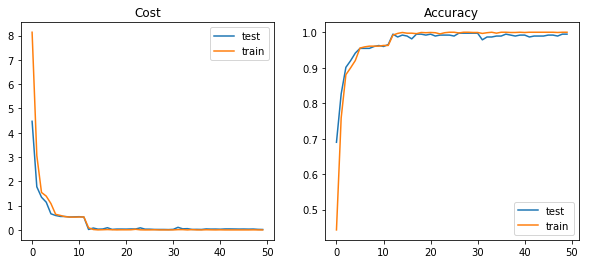

0.0121498116227
1.0


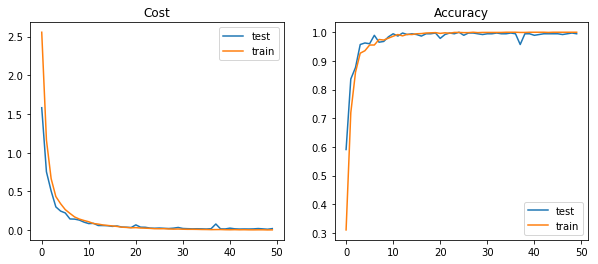

15.5578442589
0.0347593590856


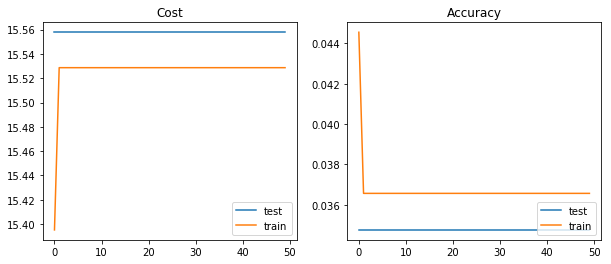

0.0217387115005
0.997326203209


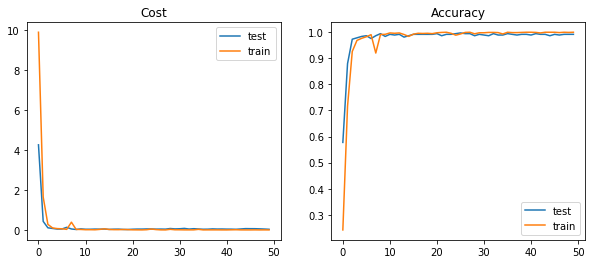

In [13]:
# PLOT CURVES

names = ["vgg", "res", "inc", "mob"]
c = 0

for n in names:
    evaluation_cost = np.load(n + "_evaluation_cost.npy")
    print(min(evaluation_cost))
    evaluation_accuracy = np.load(n + "_evaluation_accuracy.npy")
    print(max(evaluation_accuracy))
    training_cost = np.load(n + "_training_cost.npy")
    training_accuracy = np.load(n + "_training_accuracy.npy")
    c+=1

    my_plot = plot_logs(evaluation_cost, evaluation_accuracy, training_cost, training_accuracy)
    plt.show()